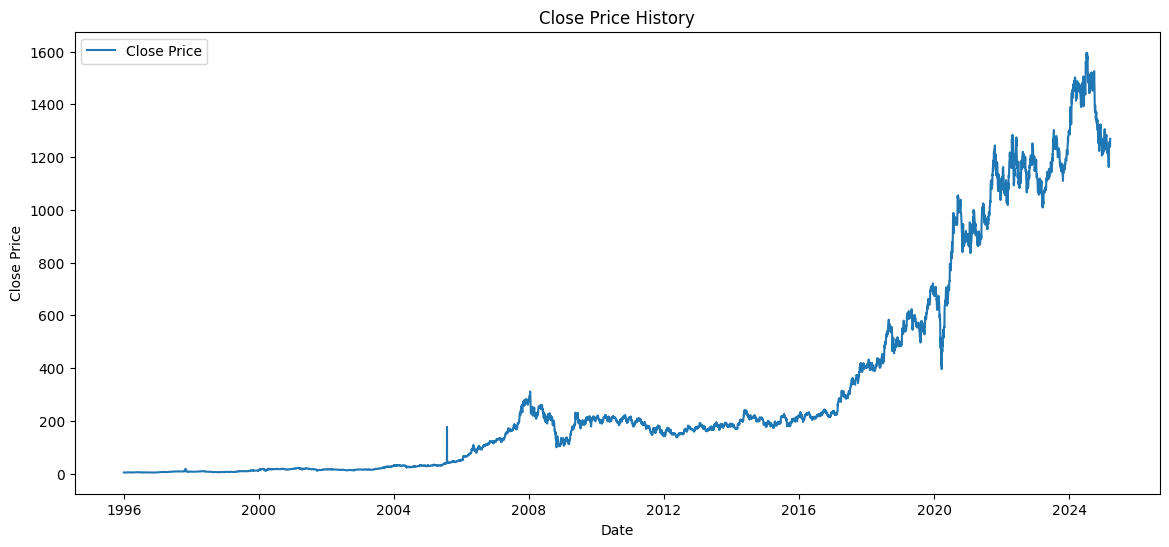

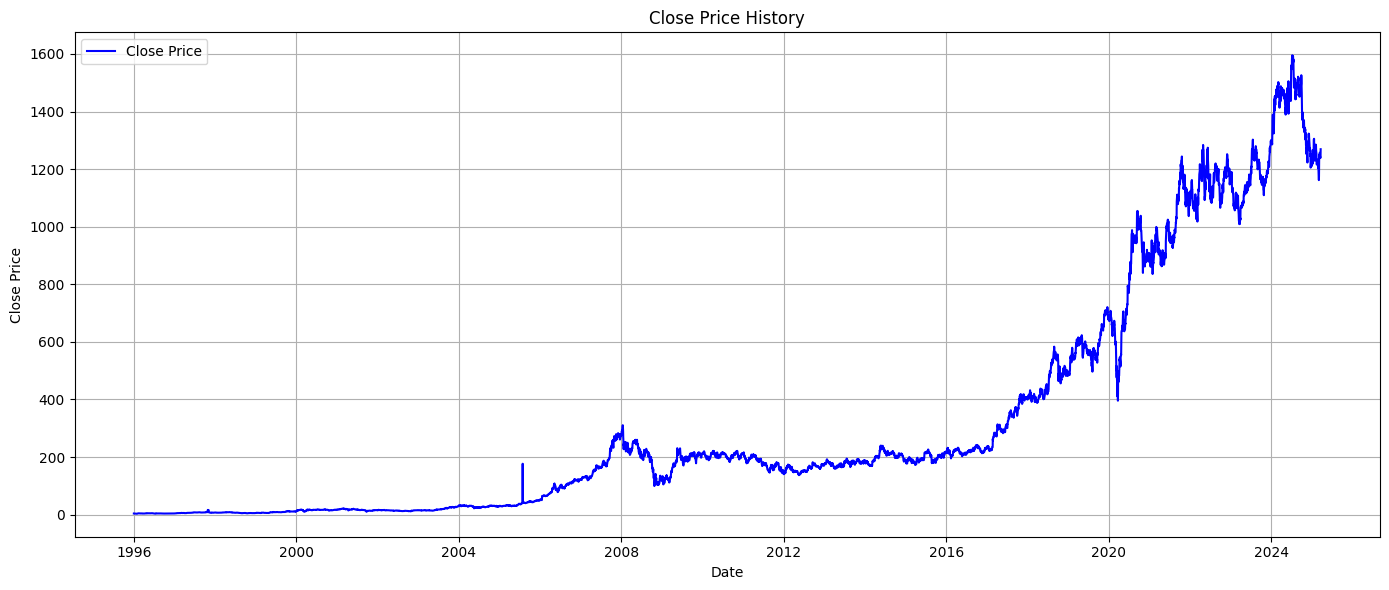

In [1]:

import pandas as pd

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


# Read data from CSV file
df = pd.read_csv('nse/RELIANCE.csv', skiprows=2,
                 names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])

# Remove rows where 'Date' column mistakenly contains the string 'Date'
df = df[df['Date'] != 'Date']

# Convert 'Date' to datetime format and handle errors explicitly
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with invalid dates
df.dropna(subset=['Date'], inplace=True)

# Sort by Date, set as index, and drop any remaining NaN values
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

# Optional: Reorder columns to standard format
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
# Visualize the data
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Enhanced visualization
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Ensure 'Volume' column is numeric
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
df.dropna(inplace=True)


In [2]:
# Data preprocessing
def preprocess_lstm_data(df, column='Close', time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[[column]])

    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i, 0])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

time_step = 60
X, y, scaler = preprocess_lstm_data(df)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [3]:

# Build the stacked LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)

# Save the model
model.save('stacked_lstm_model.h5')
print("Model saved as 'stacked_lstm_model.h5'")


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - loss: 0.0016
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - loss: 4.5581e-05
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - loss: 3.9529e-05
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - loss: 4.5452e-05
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - loss: 5.1972e-05
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - loss: 4.4511e-05
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - loss: 3.3361e-05
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - loss: 2.6813e-05
Epoch 9/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - loss: 2.5096e-05
Epoch 10/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - loss: 3.0045e-05
Epoch 11/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - loss: 2.2742e-05
Epoch 12/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - loss: 2.5251e-05
Epoch 13/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - loss: 2.8115e-05
Epoch 14/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/s

Model saved as 'stacked_lstm_model.h5'


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
RMSE: 41.649053095765574
MAE: 34.112289491590566


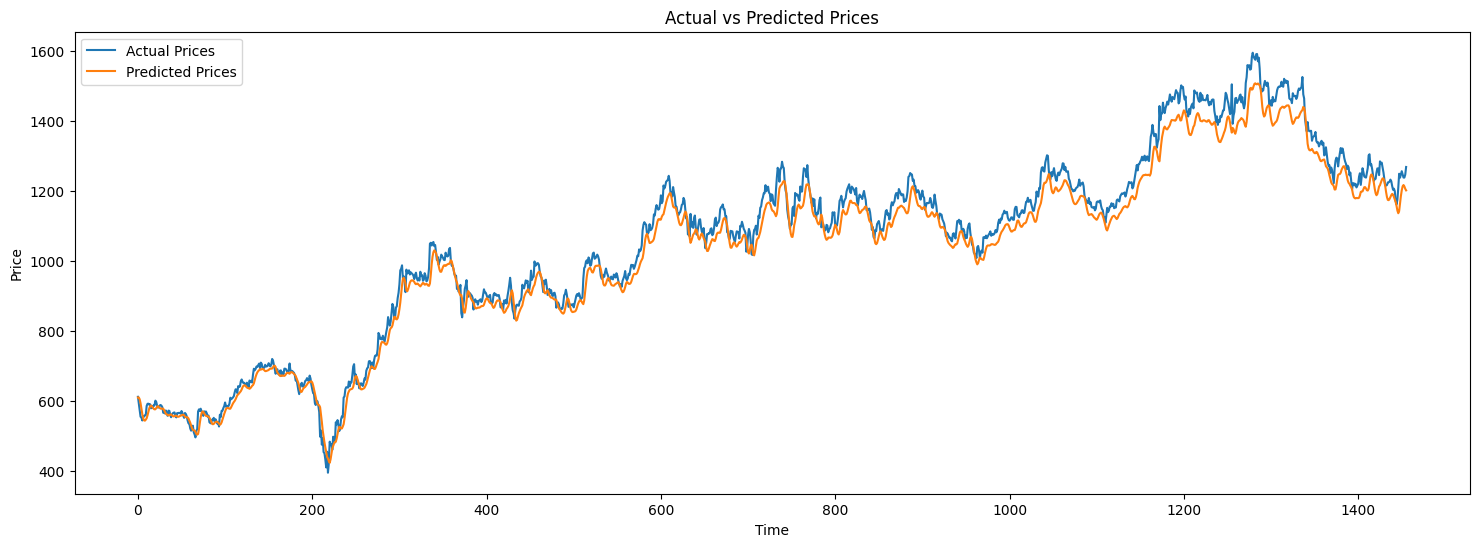

In [4]:
# Make predictions
y_pred = model.predict(X_test)

# Reverse scaling
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot predictions vs actual
plt.figure(figsize=(18, 6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(y_pred_rescaled, label='Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [5]:
# Save the trained model
model.save('stacked_lstm_model.keras')


In [6]:

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf

def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

def train_and_save_model(data, name, save_dir):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = create_sequences(scaled_data)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    es = EarlyStopping(patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[es], verbose=0)

    # Evaluation
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    print(f"Model: {name}")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
    print("MAE:", mean_absolute_error(y_test_inv, y_pred_inv))
    print("MAPE:", np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100)
    print("R^2 Score:", r2_score(y_test_inv, y_pred_inv))

    os.makedirs(save_dir, exist_ok=True)
    model.save(os.path.join(save_dir, f"{name}_model.h5"))

# Train on index CSVs
index_dir = "indices"
for file in glob.glob(os.path.join(index_dir, "*.csv")):
    df = pd.read_csv(file, skiprows=2,
                 names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])
    if 'Close' in df.columns:
        name = os.path.splitext(os.path.basename(file))[0]
        close_prices = df['Close'].dropna().values.reshape(-1, 1)
        train_and_save_model(close_prices, name, "models/indices")

# Train on TCS and HDFC
for symbol in ["TCS.NS", "HDFCBANK.NS"]:
    data = yf.download(symbol, period="10y")
    if not data.empty:
        close_prices = data['Close'].dropna().values.reshape(-1, 1)
        name = symbol.split('.')[0]
        train_and_save_model(close_prices, name, "models/nse")


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


Model: NIFTY_50
RMSE: 479.54176064011443
MAE: 384.8716275734208
MAPE: 1.8634615812690738
R^2 Score: 0.9718437543609554


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


Model: NIFTY_500
RMSE: 388.07945178852157
MAE: 297.59016445848727
MAPE: 1.6049214100214375
R^2 Score: 0.9860736295232109


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


Model: NIFTY_Bank
RMSE: 789.7877125371043
MAE: 637.584928878631
MAPE: 1.4406324459063156
R^2 Score: 0.9791196712927368


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


Model: NIFTY_FMCG
RMSE: 963.7002485209173
MAE: 756.0768534640763
MAPE: 1.4214821864711187
R^2 Score: 0.9774962432748591


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


Model: NIFTY_IT
RMSE: 646.7269676304394
MAE: 480.5266035923638
MAPE: 1.4363014396201625
R^2 Score: 0.9843377129248936


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


Model: NIFTY_Midcap_100
RMSE: 228.80761441086392
MAE: 176.95308087470272
MAPE: 1.4999583582683638
R^2 Score: 0.9945826734001633


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


Model: NIFTY_Next_50
RMSE: 2237.2990513434165
MAE: 1626.4167062737642
MAPE: 2.8827129405327967
R^2 Score: 0.9690963558331379


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


Model: S&P_BSE_Sensex
RMSE: 1698.2704996473497
MAE: 1357.143668643833
MAPE: 2.300704829532504
R^2 Score: 0.985091214732203
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


Model: TCS
RMSE: 94.93573595448605
MAE: 72.29033841334936
MAPE: 1.8655311253216185
R^2 Score: 0.9451605299712903


[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


Model: HDFCBANK
RMSE: 30.04946409672112
MAE: 22.042878083668313
MAPE: 1.3769363584909033
R^2 Score: 0.9243958892135159


In [7]:

def plot_predictions(y_test_inv, y_pred_inv, title):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))
    plt.plot(y_test_inv, label='Actual Prices')
    plt.plot(y_pred_inv, label='Predicted Prices')
    plt.title(f"{title} - Actual vs Predicted")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Modified version of train_and_save_model to include plotting
def train_and_save_model(data, name, save_dir):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = create_sequences(scaled_data)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    es = EarlyStopping(patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[es], verbose=0)

    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    print(f"Model: {name}")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
    print("MAE:", mean_absolute_error(y_test_inv, y_pred_inv))
    print("MAPE:", np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100)
    print("R^2 Score:", r2_score(y_test_inv, y_pred_inv))

    plot_predictions(y_test_inv, y_pred_inv, name)

    os.makedirs(save_dir, exist_ok=True)
    model.save(os.path.join(save_dir, f"{name}_model.h5"))


In [8]:
def forecast_next_30_days(model, last_sequence, scaler, title):
    import numpy as np
    import matplotlib.pyplot as plt

    forecast_input = last_sequence.reshape(1, -1, 1)
    forecast = []

    for _ in range(30):
        next_pred = model.predict(forecast_input, verbose=0)[0]
        forecast.append(next_pred)
        forecast_input = np.append(forecast_input[:, 1:, :], [[next_pred]], axis=1)

    forecast = np.array(forecast).reshape(-1, 1)
    forecast_prices = scaler.inverse_transform(forecast)

    # Plot forecast
    plt.figure(figsize=(10, 5))
    plt.plot(forecast_prices, marker='o', label="Forecasted Prices")
    plt.title(f"{title} - Forecast for Next 30 Days")
    plt.xlabel("Day")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [9]:
    # Forecasting
forecast_next_30_days(r'C:\GIT REPOS\Final-Sem-Project\stacked_lstm_model.keras', X_test[-1], scaler, 'test')


AttributeError: 'str' object has no attribute 'predict'